In [1]:
# Celda 1: Importaciones y Configuración del Benchmark (Actualizada)

import subprocess
import time
import pandas as pd
import matplotlib.pyplot as plt
import os
import platform
from tqdm import tqdm
import numpy as np

# --- CONFIGURACIÓN DE LA PRUEBA ---

# 1. Carpeta para guardar todos los resultados
EXPERIMENT_DIR = "experimentos"

# 2. Parámetros de la malla y los hilos
GRID_LENGTH = "100"
NTHREADS_LIST = [1, 2, 4, 8, 16]

# 3. Implementaciones de OpenMP a probar
OMP_BINARIES = [
    "yee_naive_omp",
    "yee_block_omp",
    "yee_stride1_omp"
]

# 4. Número de repeticiones para promediar resultados
REPETICIONES = 3

# 5. Detección automática de la carpeta de binarios
ARCHNAME = f"{platform.system()}_{platform.machine()}"
BIN_DIR = f"{ARCHNAME}/bin"

# 6. Nombres de los archivos de salida (ahora dentro de EXPERIMENT_DIR)
# os.path.join se encarga de unir las rutas correctamente (ej. "experimentos/resultados.csv")
OUTPUT_CSV = os.path.join(EXPERIMENT_DIR, f"resultados_omp_grid{GRID_LENGTH}.csv")
OUTPUT_PNG_TIME = os.path.join(EXPERIMENT_DIR, f"rendimiento_omp_grid{GRID_LENGTH}.png")
OUTPUT_PNG_SPEEDUP = os.path.join(EXPERIMENT_DIR, f"speedup_omp_grid{GRID_LENGTH}.png")

# --- PREPARACIÓN DEL ENTORNO ---
# Crear la carpeta de experimentos si no existe
os.makedirs(EXPERIMENT_DIR, exist_ok=True)

print("--- Configuración Cargada ---")
print(f"Directorio de resultados: {EXPERIMENT_DIR}")
print(f"Directorio de binarios:   {BIN_DIR}")
print(f"Ejecutables a probar:     {OMP_BINARIES}")
print(f"Hilos por prueba:         {NTHREADS_LIST}")
print(f"Tamaño de malla:          {GRID_LENGTH}")
print("----------------------------")
print("¡Listo para compilar en la siguiente celda!")

--- Configuración Cargada ---
Directorio de resultados: experimentos
Directorio de binarios:   Linux_x86_64/bin
Ejecutables a probar:     ['yee_naive_omp', 'yee_block_omp', 'yee_stride1_omp']
Hilos por prueba:         [1, 2, 4, 8, 16]
Tamaño de malla:          100
----------------------------
¡Listo para compilar en la siguiente celda!


In [2]:
# Celda 2: Compilar los Ejecutables

print(f"=== Compilando todos los ejecutables en '{BIN_DIR}'... ===")
try:
    # Ejecutamos 'make bin' que, según tu Makefile, compila todos los binarios.
    # Usamos capture_output=True para no llenar la salida del notebook.
    # Si hay un error, lo mostraremos.
    result = subprocess.run(["make", "bin"], check=True, capture_output=True, text=True)
    print("¡Compilación completada exitosamente!")
    
    # Verificamos que los archivos existen
    all_binaries_found = True
    for binary_name in OMP_BINARIES:
        executable_path = os.path.join(BIN_DIR, binary_name)
        if not os.path.exists(executable_path):
            print(f"ERROR: El ejecutable '{executable_path}' no se encontró después de compilar.")
            all_binaries_found = False
    
    if all_binaries_found:
        print("Todos los ejecutables necesarios fueron encontrados.")
        
except FileNotFoundError:
    print("ERROR: El comando 'make' no se encontró. ¿Está instalado y en el PATH de tu entorno WSL?")
except subprocess.CalledProcessError as e:
    print("ERROR: 'make bin' falló. Revisa tu Makefile o el código fuente.")
    print("--- Salida de Error de 'make' ---")
    print(e.stderr)
    print("---------------------------------")

=== Compilando todos los ejecutables en 'Linux_x86_64/bin'... ===
¡Compilación completada exitosamente!
Todos los ejecutables necesarios fueron encontrados.


In [3]:
# Celda 3: Ejecutar el Benchmark y Medir Tiempos (VERSIÓN DE DIAGNÓSTICO)

all_results = []
fallos_totales = 0

total_runs = len(OMP_BINARIES) * len(NTHREADS_LIST) * REPETICIONES
progress_bar = tqdm(total=total_runs, desc="Ejecutando pruebas", unit="run")

for binary_name in OMP_BINARIES:
    executable_path = os.path.join(BIN_DIR, binary_name)
    if not os.path.exists(executable_path):
        print(f"SALTANDO: {binary_name} no se encontró en {executable_path}")
        progress_bar.update(len(NTHREADS_LIST) * REPETICIONES)
        continue
        
    for n_threads in NTHREADS_LIST:
        for i in range(REPETICIONES):
            env = os.environ.copy()
            env["OMP_NUM_THREADS"] = str(n_threads)
            command = [executable_path, "-n", GRID_LENGTH]
            
            start_time = time.time()
            try:
                # Ejecutamos el comando
                subprocess.run(command, env=env, check=True, capture_output=True, text=True)
            except subprocess.CalledProcessError as e:
                # ¡AQUÍ ESTÁ LA CLAVE DEL DIAGNÓSTICO!
                print(f"\n--- FALLO DETECTADO ---")
                print(f"Comando: {' '.join(command)}")
                print(f"Hilos: {n_threads}")
                print(f"Error devuelto por el programa (Stderr):")
                print(e.stderr)
                print(f"----------------------")
                elapsed = None
                fallos_totales += 1
            else:
                end_time = time.time()
                elapsed = end_time - start_time
            
            all_results.append({
                "binary": binary_name, "threads": n_threads, "run": i + 1, "time_s": elapsed
            })
            progress_bar.update(1)
            progress_bar.set_postfix_str(f"{binary_name} @ {n_threads}T")

progress_bar.close()
print(f"\n¡Benchmark completado con {fallos_totales} fallos de ejecución!")

# Crear el DataFrame, incluso si hay fallos
df_raw_con_fallos = pd.DataFrame(all_results)

# Ahora filtramos los fallos.
df_raw = df_raw_con_fallos.dropna(subset=['time_s'])

# Verificamos si el DataFrame quedó vacío
if df_raw.empty:
    print("\n¡ADVERTENCIA! Todas las ejecuciones fallaron. El DataFrame de resultados está vacío.")
    print("Revisa los mensajes de 'FALLO DETECTADO' de arriba para depurar tu código C.")
    # Creamos un df_raw vacío para que la siguiente celda no dé error de "variable no existe",
    # pero sí detecte que está vacío.
    df_raw = pd.DataFrame(columns=['binary', 'threads', 'run', 'time_s'])
else:
    print("\nMuestra de los tiempos medidos (solo ejecuciones exitosas):")
    display(df_raw.head())

Ejecutando pruebas: 100%|█| 45/45 [00:01<00:00, 32.53run/s, yee_stride1_omp @ 16


¡Benchmark completado con 0 fallos de ejecución!

Muestra de los tiempos medidos (solo ejecuciones exitosas):


,binary,threads,run,time_s
0,yee_naive_omp,1,1,0.012798
1,yee_naive_omp,1,2,0.012319
2,yee_naive_omp,1,3,0.019976
3,yee_naive_omp,2,1,0.020600
4,yee_naive_omp,2,2,0.019620


Resultados crudos guardados en 'experimentos/resultados_omp_grid100.csv'

Tiempos de ejecución promediados (Hilos vs Tiempo):


,binary,threads,time_s
0,yee_block_omp,1,0.012030
1,yee_block_omp,2,0.012473
2,yee_block_omp,4,0.012183
3,yee_block_omp,8,0.012400
4,yee_block_omp,16,0.012412
5,yee_naive_omp,1,0.015031
6,yee_naive_omp,2,0.017409
7,yee_naive_omp,4,0.018208
8,yee_naive_omp,8,0.012062
9,yee_naive_omp,16,0.012165



Generando gráfica de rendimiento y guardando en 'experimentos/rendimiento_omp_grid100.png'...


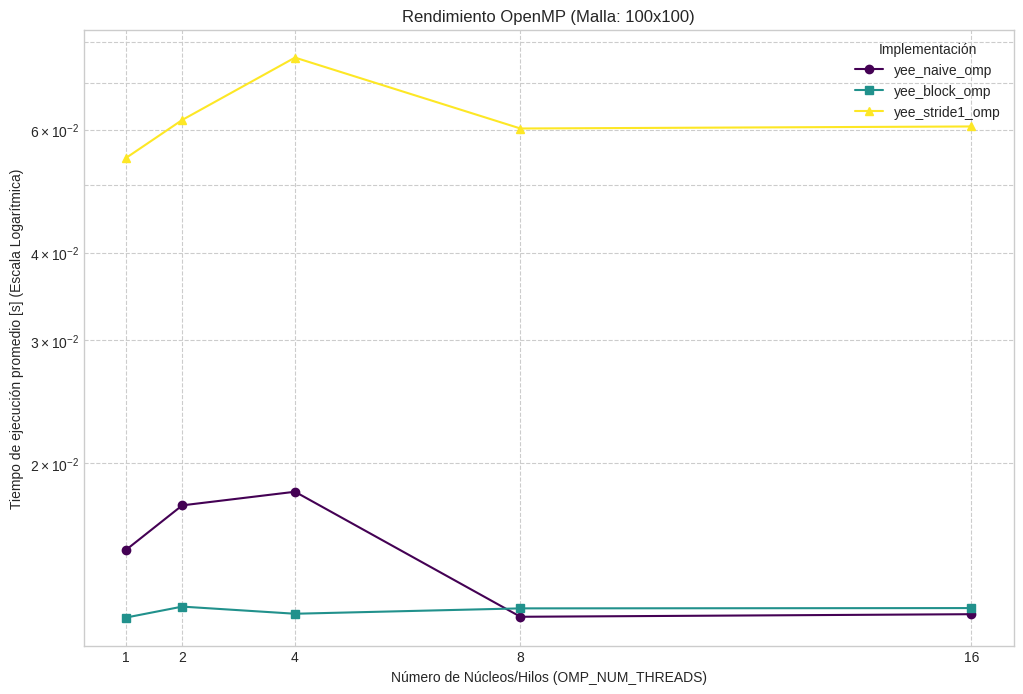

In [4]:
# Celda 4: Procesar Datos y Generar Gráfica de Tiempo vs. Cores (Actualizada)

if 'df_raw' in locals() and not df_raw.empty:
    # 1. Guardar los resultados crudos en el directorio de experimentos
    df_raw.to_csv(OUTPUT_CSV, index=False)
    print(f"Resultados crudos guardados en '{OUTPUT_CSV}'")

    # 2. Calcular el tiempo promedio para cada configuración
    # Esto ya te da la tabla de hilos vs tiempo que necesitas
    df_mean = df_raw.groupby(["binary", "threads"])["time_s"].mean().reset_index()

    print("\nTiempos de ejecución promediados (Hilos vs Tiempo):")
    display(df_mean)

    # 3. Generar la gráfica de Tiempo vs. Cores
    print(f"\nGenerando gráfica de rendimiento y guardando en '{OUTPUT_PNG_TIME}'...")
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 8))

    colors = plt.cm.viridis(np.linspace(0, 1, len(OMP_BINARIES)))
    markers = ['o', 's', '^']

    for i, binary_name in enumerate(OMP_BINARIES):
        subset = df_mean[df_mean["binary"] == binary_name]
        ax.plot(
            subset["threads"],
            subset["time_s"],
            marker=markers[i],
            linestyle='-',
            color=colors[i],
            label=binary_name
        )

    ax.set_xlabel("Número de Núcleos/Hilos (OMP_NUM_THREADS)")
    ax.set_ylabel("Tiempo de ejecución promedio [s] (Escala Logarítmica)")
    ax.set_title(f"Rendimiento OpenMP (Malla: {GRID_LENGTH}x{GRID_LENGTH})")
    ax.set_xticks(NTHREADS_LIST)
    ax.set_yscale('log')
    ax.grid(True, which="both", linestyle='--')
    ax.legend(title="Implementación")

    plt.savefig(OUTPUT_PNG_TIME, dpi=300, bbox_inches='tight')
    plt.show()

else:
    print("No se generaron resultados válidos. No se pueden procesar los datos.")

Tabla de Speedup (Aceleración):


,binary,threads,time_s,speedup
5,yee_naive_omp,1,0.015031,1.000000
6,yee_naive_omp,2,0.017409,0.863371
7,yee_naive_omp,4,0.018208,0.825506
8,yee_naive_omp,8,0.012062,1.246146
9,yee_naive_omp,16,0.012165,1.235603
0,yee_block_omp,1,0.012030,1.000000
1,yee_block_omp,2,0.012473,0.964484
2,yee_block_omp,4,0.012183,0.987430
3,yee_block_omp,8,0.012400,0.970128
4,yee_block_omp,16,0.012412,0.969171



Generando gráfica de speedup y guardando en 'experimentos/speedup_omp_grid100.png'...


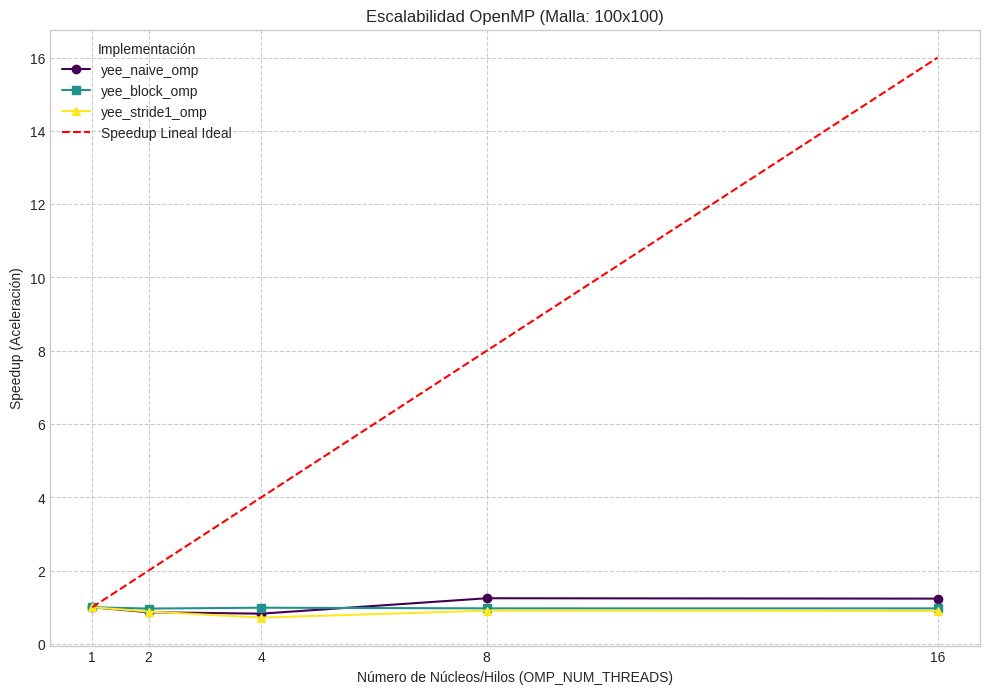

In [5]:
# Celda 5: Calcular y Graficar el Speedup (Hilos vs. Aceleración)

if 'df_mean' in locals() and not df_mean.empty:
    # 1. Calcular el Speedup
    df_speedup = pd.DataFrame()
    for binary_name in OMP_BINARIES:
        subset = df_mean[df_mean["binary"] == binary_name].copy()
        # Tomar el tiempo base (con 1 hilo) para esta implementación
        time_1_thread = subset[subset["threads"] == 1]["time_s"].iloc[0]
        # Calcular el speedup: Tiempo(1 hilo) / Tiempo(N hilos)
        subset["speedup"] = time_1_thread / subset["time_s"]
        df_speedup = pd.concat([df_speedup, subset])
        
    print("Tabla de Speedup (Aceleración):")
    display(df_speedup)

    # 2. Generar la gráfica de Speedup vs. Cores
    print(f"\nGenerando gráfica de speedup y guardando en '{OUTPUT_PNG_SPEEDUP}'...")
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 8))

    colors = plt.cm.viridis(np.linspace(0, 1, len(OMP_BINARIES)))
    markers = ['o', 's', '^']

    for i, binary_name in enumerate(OMP_BINARIES):
        subset = df_speedup[df_speedup["binary"] == binary_name]
        ax.plot(
            subset["threads"],
            subset["speedup"],
            marker=markers[i],
            linestyle='-',
            color=colors[i],
            label=binary_name
        )

    # Añadir la línea de "Speedup Lineal Perfecto" como referencia
    ax.plot(NTHREADS_LIST, NTHREADS_LIST, linestyle='--', color='red', label='Speedup Lineal Ideal')
    
    ax.set_xlabel("Número de Núcleos/Hilos (OMP_NUM_THREADS)")
    ax.set_ylabel("Speedup (Aceleración)")
    ax.set_title(f"Escalabilidad OpenMP (Malla: {GRID_LENGTH}x{GRID_LENGTH})")
    ax.set_xticks(NTHREADS_LIST)
    ax.grid(True, which="both", linestyle='--')
    ax.legend(title="Implementación")

    plt.savefig(OUTPUT_PNG_SPEEDUP, dpi=300, bbox_inches='tight')
    plt.show()

else:
    print("No se generaron resultados válidos. No se puede calcular el speedup.")

In [6]:
# Celda 6 (OpenMP): Benchmark de Tamaño de Malla con 8 Hilos

print("\n--- INICIANDO BENCHMARK DE TAMAÑO DE MALLA (OpenMP) ---")

# --- Configuración para esta prueba ---
NTHREADS_FIXED_OMP = 8
GRID_LENGTH_LIST_OMP = np.arange(500, 1010, 50)
REPETICIONES_GRID_OMP = 1 # 1 es suficiente para esta gráfica
OUTPUT_CSV_GRIDSIZE_OMP = os.path.join(EXPERIMENT_DIR, f"resultados_gridsize_omp_n{NTHREADS_FIXED_OMP}.csv")

results_grid_omp = []
total_runs = len(OMP_BINARIES) * len(GRID_LENGTH_LIST_OMP) * REPETICIONES_GRID_OMP
progress_bar = tqdm(total=total_runs, desc=f"OpenMP @ {NTHREADS_FIXED_OMP} hilos", unit="run")

# Bucle principal sobre el tamaño de la malla
for grid_length in GRID_LENGTH_LIST_OMP:
    grid_length_str = str(grid_length)
    for binary_name in OMP_BINARIES:
        for i in range(REPETICIONES_GRID_OMP):
            executable_path = os.path.join(BIN_DIR, binary_name)
            env = os.environ.copy()
            env["OMP_NUM_THREADS"] = str(NTHREADS_FIXED_OMP)
            command = [executable_path, "-n", grid_length_str]
            
            start_time = time.time()
            try:
                subprocess.run(command, env=env, check=True, capture_output=True, text=True)
                elapsed = time.time() - start_time
                results_grid_omp.append({"binary": binary_name, "grid_size": grid_length, "time_s": elapsed})
            except Exception as e:
                print(f"Fallo en {binary_name} con malla {grid_length}: {e}")
            progress_bar.update(1)

progress_bar.close()

# Guardar resultados
if results_grid_omp:
    df_grid_omp = pd.DataFrame(results_grid_omp)
    df_grid_omp.to_csv(OUTPUT_CSV_GRIDSIZE_OMP, index=False)
    print(f"\nResultados de tamaño de malla para OpenMP guardados en '{OUTPUT_CSV_GRIDSIZE_OMP}'")
    display(df_grid_omp.head())
else:
    print("\nNo se recolectaron datos para el benchmark de tamaño de malla de OpenMP.")


--- INICIANDO BENCHMARK DE TAMAÑO DE MALLA (OpenMP) ---


OpenMP @ 8 hilos:   6%|█▌                       | 2/33 [00:00<00:14,  2.15run/s]

KeyboardInterrupt: 